In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
# from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from collections import defaultdict
# from textwrap import wrap

# Misc.
import warnings
warnings.filterwarnings('ignore')

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import InputExample, InputFeatures
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)

2023-09-08 17:50:32.755544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load dataset

In [2]:
df = pd.read_csv('/Users/twoon/Downloads/TrainDataACHReversal_modified_2023-8-1_1752.csv')
df.columns = list(df.columns.str.lower())
df.head(5)

,bv_transaction_id,amount,description,memo,categorization,transaction_date,bank_name,provider,bank_status,is_chb
0,287dac6f-a6d2-4af1-a7ca-b0eb38840c11,370.96,Direct Debit: 4250411835 Direct Debit Instacas...,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-20 00:00:00.000,Chime Bank,PLAID,REMOVED,1
1,73617b82-261d-46f0-932f-66dc7d37c932,64.99,Reversal: INSTACASH PAYMEN MONEYLION 6310dc5d,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-19 00:00:00.000,Chase,PLAID,UNLINKED,1
2,10d6a05b-b9ab-4d58-89c3-1fb5b7a54e69,525.95,Dispute Final Credit,Transfer Credit,"Transfer, Credit",2023-03-28 00:00:00.000,Huntington Bank,PLAID,COMPLETE,1
3,f74cbfe6-54e2-4051-837a-1ef1dc002c20,832.35,INSTACASH PAYMEN REVERSAL,Transfer Credit,"Transfer, Credit",2022-09-07 00:00:00.000,TD Bank,PLAID,REMOVED,1
4,70e0aeac-14c1-4e95-b08f-0b10a3743475,212.00,INSTACASH PAYMEN,Transfer Credit,"Transfer, Credit",2022-10-06 00:00:00.000,Capital One,PLAID,REMOVED,1


In [3]:
df['short_desc'] = df['description'].apply(lambda x: 
                                             x if len(x) <= 30 else 
                                             (x[:30] if x[30]==' ' else 
                                              (x[:x[30:].index(' ') + 30] if ' ' in x[30:] else x)
                                             )
                                            )                                        
df.head(5)

,bv_transaction_id,amount,description,memo,categorization,transaction_date,bank_name,provider,bank_status,is_chb,short_desc
0,287dac6f-a6d2-4af1-a7ca-b0eb38840c11,370.96,Direct Debit: 4250411835 Direct Debit Instacas...,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-20 00:00:00.000,Chime Bank,PLAID,REMOVED,1,Direct Debit: 4250411835 Direct
1,73617b82-261d-46f0-932f-66dc7d37c932,64.99,Reversal: INSTACASH PAYMEN MONEYLION 6310dc5d,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-19 00:00:00.000,Chase,PLAID,UNLINKED,1,Reversal: INSTACASH PAYMEN MONEYLION
2,10d6a05b-b9ab-4d58-89c3-1fb5b7a54e69,525.95,Dispute Final Credit,Transfer Credit,"Transfer, Credit",2023-03-28 00:00:00.000,Huntington Bank,PLAID,COMPLETE,1,Dispute Final Credit
3,f74cbfe6-54e2-4051-837a-1ef1dc002c20,832.35,INSTACASH PAYMEN REVERSAL,Transfer Credit,"Transfer, Credit",2022-09-07 00:00:00.000,TD Bank,PLAID,REMOVED,1,INSTACASH PAYMEN REVERSAL
4,70e0aeac-14c1-4e95-b08f-0b10a3743475,212.00,INSTACASH PAYMEN,Transfer Credit,"Transfer, Credit",2022-10-06 00:00:00.000,Capital One,PLAID,REMOVED,1,INSTACASH PAYMEN


In [4]:
df = df[df['bank_name']!='Chime Bank']

In [5]:
df.is_chb.value_counts()

0    6304
1    4724
Name: is_chb, dtype: int64

#### Remove some columns

In [6]:
df_bert = df[['description', 'short_desc', 'bank_name', 'is_chb']][0:5000] #experiment with 2000 rows first

### BERT

#### Encode (Tokenize) description

In [7]:
# define tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation = True)
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
df_bert['encode']=df_bert['short_desc'].apply(lambda x: tokenizer.encode(x, 
                                                                         truncation = True,
                                                                         max_length=512, 
                                                                         return_tensors='pt'))

In [9]:
with torch.no_grad():
    df_bert['emb'] = df_bert['encode'].apply(lambda x: model(x)[0])

In [30]:
# Define Chargeback Text
chb_bck_text = ['ACH DISPUTE',
                'Adjustment - Cr ',
                'Misc. Credit Adjustment on',
                'ACH Claim#',
                'Reversal']
emb_cb_mean = []

for text in chb_bck_text:
    encode_cb = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        emb_cb = model(encode_cb)[0]
    
    emb_cb_mean.append(emb_cb.mean(axis=1))

In [31]:
# calculate cosine similarity
if 'avg_cos_sim' in df_bert.columns:
    df_bert.drop('avg_cos_sim', axis=1, inplace=True)

if 'cos_sim' in globals():     
    for i in range(1,len(cos_sim)+1):
        if 'cos_sim'+f'{i}' in df_bert.columns:
            df_bert.drop('cos_sim'+f'{i}', axis=1, inplace=True)
    
cos_sim = []

for i in range(1,len(chb_bck_text)+1):
    cos_sim.append('cos_sim'+f'{i}') 

for i in range(len(cos_sim)):
    df_bert[cos_sim[i]] = df_bert['emb'].apply(lambda x: torch.cosine_similarity(emb_cb_mean[i], x.mean(axis=1)))
    df_bert[cos_sim[i]] = df_bert[cos_sim[i]].astype('float32')
    
idx = df_bert.columns.get_loc(cos_sim[0])
df_bert['avg_cos_sim'] = df_bert.iloc[:,idx:(idx+len('cos_sim')+1)].sum(axis=1)/len(cos_sim)

Minimum cosine similarity between the comparison text and chargeback description : 0.382


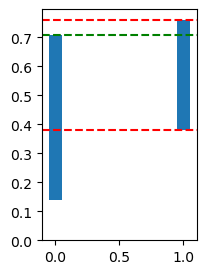

In [32]:
min_val = [df_bert[df_bert['is_chb'] == 0]['avg_cos_sim'].min(), df_bert[df_bert['is_chb'] == 1]['avg_cos_sim'].min()]
max_val = [df_bert[df_bert['is_chb'] == 0]['avg_cos_sim'].max(), df_bert[df_bert['is_chb'] == 1]['avg_cos_sim'].max()]

x = np.arange(2)

fig = plt.figure(figsize = (2, 3))

plt.bar(x, max_val, 0.1)
plt.bar(x, min_val, 0.1, color='white')
plt.axhline(y=df_bert[df_bert['is_chb'] == 1]['avg_cos_sim'].min(), color='r', linestyle='--')
plt.axhline(y=df_bert[df_bert['is_chb'] == 1]['avg_cos_sim'].max(), color='r', linestyle='--')
plt.axhline(y=df_bert[df_bert['is_chb'] == 0]['avg_cos_sim'].max(), color='g', linestyle='--')

word = round(df_bert[df_bert['is_chb'] == 1]['avg_cos_sim'].min(),3)

print(f'Minimum cosine similarity between the comparison text and chargeback description : {word}')
    

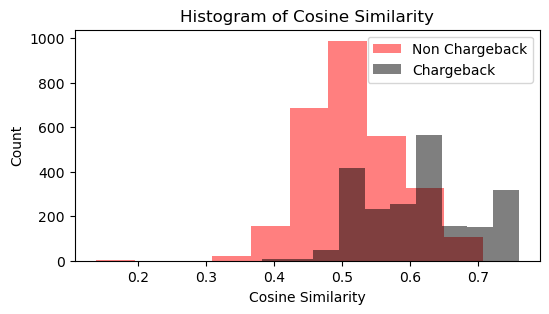

In [49]:
x = df_bert['is_chb'].to_list()
y = df_bert['avg_cos_sim'].to_list()

plt.figure(figsize = (6,3))

# KDE plot of cosine similarity
plt.hist(df_bert[df_bert['is_chb'] == 0]['avg_cos_sim'], label = 'Non Chargeback', fc = (1, 0, 0, 0.5))
plt.hist(df_bert[df_bert['is_chb'] == 1]['avg_cos_sim'], label = 'Chargeback', fc=(0, 0, 0, 0.5))
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title(f'Histogram of Cosine Similarity')
plt.legend()
plt.savefig('taking_average_hist.png')
plt.show()

In [48]:
threshold = 0.635
cb = df_bert[(df_bert['is_chb'] == 1) & (df_bert['avg_cos_sim'] > threshold)].short_desc.count()
total_cb = df_bert[(df_bert['is_chb'] == 1)].short_desc.count()

fp_cb = df_bert[(df_bert['is_chb'] == 0) & (df_bert['avg_cos_sim'] > threshold)].short_desc.count()
total_ncb = df_bert[(df_bert['is_chb'] == 0)].short_desc.count()

print(f'Number of chargeback transactions above {threshold} : {cb}')
print(f'Poportion in terms of total chargeback transactions : {round(cb*100/total_cb,2)}%')
# print('\n')
print(f'Number of non chargeback transactions above {threshold} : {fp_cb}')
print(f'Poportion in terms of total non chargeback transactions : {round(fp_cb*100/total_ncb,2)}%')

Number of chargeback transactions above 0.635 : 675
Poportion in terms of total chargeback transactions : 31.34%
Number of non chargeback transactions above 0.635 : 153
Poportion in terms of total non chargeback transactions : 5.38%


In [35]:
# plot roc_auc curve
x = np.arange(21)*0.05
tpr = []
fpr = []
precision = []
accuracy = []
recall = []

# calculate true positive rate, false positive rate and precision
for i in x:
    threshold = i

    tp = df_bert[(df_bert['is_chb'] == 1) & (df_bert['avg_cos_sim'] > threshold)].short_desc.count()
    total_positive = df_bert[(df_bert['is_chb'] == 1)].short_desc.count() # TP + FN
    tpr.append(tp/total_positive)
    
    fp = df_bert[(df_bert['is_chb'] == 0) & (df_bert['avg_cos_sim'] > threshold)].short_desc.count()
    total_negative = df_bert[(df_bert['is_chb'] == 0)].short_desc.count() # FP + TN
    fpr.append(fp/total_negative)
    
    positive_predicted = df_bert[df_bert['avg_cos_sim'] > threshold].short_desc.count() # TP + FP
    precision.append(tp/positive_predicted)
    
    tn = df_bert[(df_bert['is_chb'] == 0) & (df_bert['avg_cos_sim'] < threshold)].short_desc.count()
    total = df_bert.short_desc.count()
    accuracy.append((tp+tn)/total)
    
    total_positive = df_bert[(df_bert['is_chb']==1)].short_desc.count()
    recall.append(tp/total_positive)

In [36]:
threshold = 0.65

tp = df_bert[(df_bert['is_chb']==1) & (df_bert['avg_cos_sim']>threshold)].short_desc.count()
fn = df_bert[(df_bert['is_chb']==1) & (df_bert['avg_cos_sim']<threshold)].short_desc.count()
fp = df_bert[(df_bert['is_chb']==0) & (df_bert['avg_cos_sim']>threshold)].short_desc.count()
tn = df_bert[(df_bert['is_chb']==0) & (df_bert['avg_cos_sim']<threshold)].short_desc.count()

total_positive = df_bert[(df_bert['is_chb']==1)].short_desc.count()
total_negative = df_bert[(df_bert['is_chb']==0)].short_desc.count()

total = df_bert.short_desc.count()

positive_predicted = df_bert[df_bert['avg_cos_sim'] > threshold].short_desc.count() 

print(f'true positive : {tp}')
print(f'false negative : {fn}')
print(f'false positive : {fp}')
print(f'true negative : {tn}')
print(f'total positive : {total_positive}')
print(f'total negative : {total_negative}')
print(f'total : {total}')
print(f'positive predicted : {positive_predicted}')

true positive : 589
false negative : 1565
false positive : 105
true negative : 2741
total positive : 2154
total negative : 2846
total : 5000
positive predicted : 694


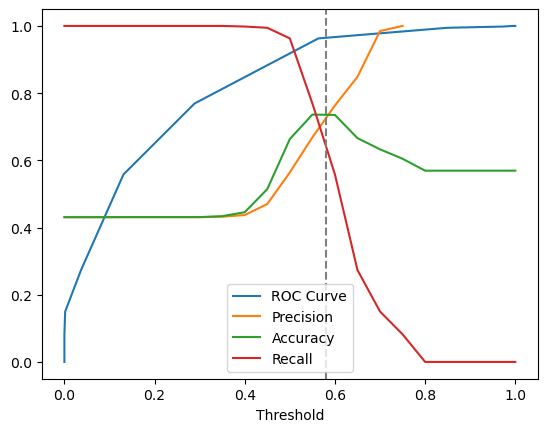

Threshold : 0.58
Precision : 0.72
Accuracy : 0.74
Recall : 0.64


In [37]:
plt.plot(fpr,tpr, label='ROC Curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')

plt.plot(x, precision, label='Precision')
# plt.xlabel('Threshold')
# plt.ylabel('Precision')
# plt.title('Precision')

plt.plot(x, accuracy, label='Accuracy')
# plt.xlabel('Threshold')
# plt.ylabel('Accuracy')
# plt.title('Accuracy')

plt.plot(x, recall, label='Recall')
plt.xlabel('Threshold')
# plt.ylabel('Recall')
# plt.title('Recall')

threshold = 0.58

plt.axvline(x=threshold, color='gray', linestyle='--')
plt.legend()
plt.show()

tp = df_bert[(df_bert['is_chb']==1) & (df_bert['avg_cos_sim']>threshold)].short_desc.count()
fn = df_bert[(df_bert['is_chb']==1) & (df_bert['avg_cos_sim']<threshold)].short_desc.count()
fp = df_bert[(df_bert['is_chb']==0) & (df_bert['avg_cos_sim']>threshold)].short_desc.count()
tn = df_bert[(df_bert['is_chb']==0) & (df_bert['avg_cos_sim']<threshold)].short_desc.count()

total_positive = df_bert[(df_bert['is_chb']==1)].short_desc.count()
total_negative = df_bert[(df_bert['is_chb']==0)].short_desc.count()

total = df_bert.short_desc.count()

positive_predicted = df_bert[df_bert['avg_cos_sim'] > threshold].short_desc.count() 


print(f'Threshold : {threshold}')
print(f'Precision : {round(tp/positive_predicted,2)}') 
print(f'Accuracy : {round((tp+tn)/total,2)}')
print(f'Recall : {round(tp/total_positive,2)}')

In [38]:
df_bert[(df_bert['is_chb'] == 1) & (df_bert['avg_cos_sim'] < 0.53)].drop(['encode','emb'],axis=1).sort_values(by = 'avg_cos_sim', 
                                                                                                          ascending = True).tail(25)

,description,short_desc,bank_name,is_chb,cos_sim1,cos_sim2,cos_sim3,cos_sim4,cos_sim5,avg_cos_sim
6831,INSTACASH PAYMEN HIST RTN 230616 63df290c7d16a...,INSTACASH PAYMEN HIST RTN 230616,Wells Fargo,1,0.574845,0.517323,0.550932,0.578596,0.411433,0.526626
6853,INSTACASH PAYMEN HIST RTN 230616 63642ba4d791a...,INSTACASH PAYMEN HIST RTN 230616,Wells Fargo,1,0.574845,0.517323,0.550932,0.578596,0.411433,0.526626
2200,INSTACASH PAYMEN HIST RTN 221007 5af3d393b3033...,INSTACASH PAYMEN HIST RTN 221007,Wells Fargo,1,0.567886,0.524277,0.561850,0.574519,0.406173,0.526941
4397,INSTACASH PAYMEN HIST RTN 221007 61a6527cd1363...,INSTACASH PAYMEN HIST RTN 221007,Wells Fargo,1,0.567886,0.524277,0.561850,0.574519,0.406173,0.526941
5044,INSTACASH PAYMEN HIST RTN 230227 63dea2557d16a...,INSTACASH PAYMEN HIST RTN 230227,Wells Fargo,1,0.570722,0.521543,0.560606,0.575874,0.406341,0.527017
4851,INSTACASH PAYMEN HIST RTN 230227 5b74b6919a9b4...,INSTACASH PAYMEN HIST RTN 230227,Wells Fargo,1,0.570722,0.521543,0.560606,0.575874,0.406341,0.527017
3857,INSTACASH PAYMEN HIST RTN 230227 5cf5e97bdce70...,INSTACASH PAYMEN HIST RTN 230227,Wells Fargo,1,0.570722,0.521543,0.560606,0.575874,0.406341,0.527017
3356,INSTACASH PAYMEN HIST RTN 230227 6342f5f3b2338...,INSTACASH PAYMEN HIST RTN 230227,Wells Fargo,1,0.570722,0.521543,0.560606,0.575874,0.406341,0.527017
4787,INSTACASH PAYMEN HIST RTN 221025 633664e69573b...,INSTACASH PAYMEN HIST RTN 221025,Wells Fargo,1,0.571536,0.524622,0.555426,0.580486,0.405016,0.527417
5752,INSTACASH PAYMEN HIST RTN 221025 628e2da15ae41...,INSTACASH PAYMEN HIST RTN 221025,Wells Fargo,1,0.571536,0.524622,0.555426,0.580486,0.405016,0.527417


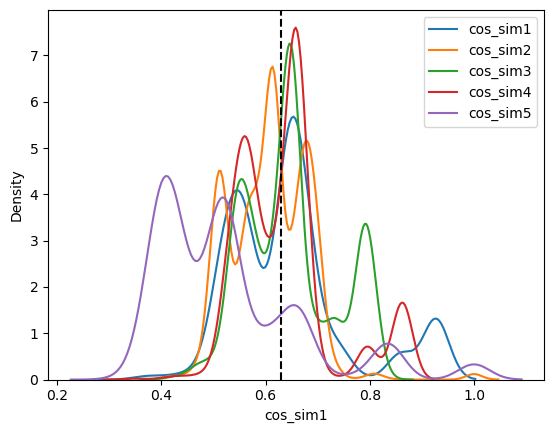

In [39]:
sns.kdeplot(df_bert[df_bert['is_chb'] == 1]['cos_sim1'], label = 'cos_sim1')
sns.kdeplot(df_bert[df_bert['is_chb'] == 1]['cos_sim2'], label = 'cos_sim2')
sns.kdeplot(df_bert[df_bert['is_chb'] == 1]['cos_sim3'], label = 'cos_sim3')
sns.kdeplot(df_bert[df_bert['is_chb'] == 1]['cos_sim4'], label = 'cos_sim4')
sns.kdeplot(df_bert[df_bert['is_chb'] == 1]['cos_sim5'], label = 'cos_sim5')
plt.axvline(x=0.63, color='black', linestyle ='--')
plt.legend()

In [147]:
df_bert[(df_bert['is_chb'] == 0) & (df_bert['avg_cos_sim'] > threshold)].drop(['encode','emb'],axis=1).sort_values(by = 'avg_cos_sim', 
                                                                                                                   ascending = False).tail(25)

,description,short_desc,bank_name,is_chb,cos_sim1,cos_sim2,cos_sim3,cos_sim4,cos_sim5,cos_sim6,cos_sim7,avg_cos_sim
2282,Transfer from Checking SAV TRF FR OTHER,Transfer from Checking SAV TRF,Navy Federal Credit Union,0,0.606806,0.543876,0.639924,0.674439,0.643956,0.585857,0.428945,0.589115
1592,IN-SHAPE 171 VIC DES:CLUB FEES ID:M3247702 IND...,IN-SHAPE 171 VIC DES:CLUB FEES,Bank of America,0,0.625399,0.518489,0.654545,0.624092,0.642852,0.603655,0.452345,0.588768
2841,Klarna COLUMBUS OH,Klarna COLUMBUS OH,USAA,0,0.628268,0.535680,0.615801,0.649058,0.555361,0.608319,0.528293,0.588683
626,Withdrawal / OPC*FIN SERVICE FEE 888-829-7302 ...,Withdrawal / OPC*FIN SERVICE FEE,Atlanta Postal Credit Union,0,0.657575,0.577326,0.638140,0.607380,0.658783,0.584880,0.395328,0.588487
2004,Transfer to Checking TRF TO SHARES,Transfer to Checking TRF TO SHARES,Navy Federal Credit Union,0,0.618708,0.506780,0.634168,0.710543,0.667591,0.576761,0.401519,0.588010
2734,PURCHASE AUTHORIZED ON 02/12 CMX BRICKELL CITY...,PURCHASE AUTHORIZED ON 02/12 CMX,Wells Fargo,0,0.555335,0.568644,0.600162,0.616901,0.621468,0.633350,0.519354,0.587888
2018,Non-Sufficient Funds Charge Brigit-com - MEMBE...,Non-Sufficient Funds Charge Brigit-com,Travis Credit Union,0,0.667362,0.547279,0.596586,0.616978,0.678628,0.567249,0.438593,0.587525
2828,EB From Checking 4237,EB From Checking 4237,Regions Bank,0,0.577022,0.540357,0.615801,0.659829,0.580330,0.632775,0.502429,0.586935
1819,Pos Adjustment - Cr Instacash Funds New York N...,Pos Adjustment - Cr Instacash Funds,Navy Federal Credit Union,0,0.705331,0.436532,0.687739,0.640090,0.754660,0.547678,0.335682,0.586816
1181,Withdrawal ANGEL SPIRIT DELI / PHILADELPHIA PA...,Withdrawal ANGEL SPIRIT DELI /,Philadelphia Federal Credit Union,0,0.606755,0.595928,0.650963,0.622037,0.611232,0.574815,0.444981,0.586673


In [137]:
df_bert[(df_bert['is_chb'] == 1)].drop(['encode','emb'],axis=1).sort_values(by = 'cos_sim', ascending = True).head(25)

,description,short_desc,bank_name,is_chb,cos_sim
2379,DEBIT CARD REFUND,DEBIT CARD REFUND,USAA,1,0.390360
345,MoneyLion,MoneyLion,Desert Financial Credit Union - Personal,1,0.466314
1706,NOT AUTHORIZED,NOT AUTHORIZED,First Citizens State Bank - Personal,1,0.478790
2201,Provisional Credit,Provisional Credit,Charles Schwab,1,0.498330
303,CREDIT MEMO,CREDIT MEMO,"United Bank (DC, MD, OH, PA, VA, WV) - Persona...",1,0.556957
1919,Reversal,Reversal,Navy Federal Credit Union,1,0.557029
562,Reversal,Reversal,Navy Federal Credit Union,1,0.557029
565,Reversal,Reversal,Navy Federal Credit Union,1,0.557029
1659,Reversal,Reversal,Navy Federal Credit Union,1,0.557029
581,Reversal,Reversal,Navy Federal Credit Union,1,0.557029


In [329]:
new_df = df_bert.drop(['cos_sim1', 'avg_cos_sim'],axis=1)
new_df

,description,short_desc,bank_name,is_chb,encode,emb
1,Reversal: INSTACASH PAYMEN MONEYLION 6310dc5d,Reversal: INSTACASH PAYMEN MONEYLION,Chase,1,"[[tensor(101), tensor(23163), tensor(1024), te...","[[[tensor(-0.3710), tensor(0.1419), tensor(-0...."
2,Dispute Final Credit,Dispute Final Credit,Huntington Bank,1,"[[tensor(101), tensor(7593), tensor(2345), ten...","[[[tensor(-0.2542), tensor(0.1483), tensor(-0...."
3,INSTACASH PAYMEN REVERSAL,INSTACASH PAYMEN REVERSAL,TD Bank,1,"[[tensor(101), tensor(16021), tensor(2696), te...","[[[tensor(-0.6520), tensor(0.1356), tensor(-0...."
4,INSTACASH PAYMEN,INSTACASH PAYMEN,Capital One,1,"[[tensor(101), tensor(16021), tensor(2696), te...","[[[tensor(-0.5745), tensor(0.3141), tensor(-0...."
7,ACH DISPUTE CREDIT,ACH DISPUTE CREDIT,PNC,1,"[[tensor(101), tensor(9353), tensor(2232), ten...","[[[tensor(-0.3410), tensor(0.0767), tensor(-0...."
...,...,...,...,...,...,...
7174,Withdrawal Debit Card DUNKIN #354623 Q35 865-8...,Withdrawal Debit Card DUNKIN #354623,Ascend Federal Credit Union,0,"[[tensor(101), tensor(10534), tensor(2139), te...","[[[tensor(-0.5826), tensor(-0.0028), tensor(-0..."
7175,WM SUPERC WAL-MART SUP 07-13-23ARLINGTON 7392 ...,WM SUPERC WAL-MART SUP 07-13-23ARLINGTON,Truist,0,"[[tensor(101), tensor(1059), tensor(2213), ten...","[[[tensor(-0.6581), tensor(-0.1743), tensor(-0..."
7176,Withdrawal #222618436709 / SHELL SERVICE STATI...,Withdrawal #222618436709 / SHELL,Arizona Federal Credit Union,0,"[[tensor(101), tensor(10534), tensor(1001), te...","[[[tensor(-1.0279), tensor(-0.0183), tensor(-0..."
7177,Klarna,Klarna,Regions Bank,0,"[[tensor(101), tensor(1047), tensor(8017), ten...","[[[tensor(-0.2730), tensor(-0.0524), tensor(-0..."


In [330]:
new_df.to_csv('ACH_Train_Data_Embedded')